In [20]:
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
with open('config.json', 'r') as file:
    config = json.load(file)

In [6]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']

# Consequent params fitting

In [11]:
with open(f'{research_results_folder}/fitting_consequent_params_result_2022-01-23_02-06-06.894188.pkl', 'rb') as file:
    res = pd.read_pickle(file)

In [17]:
res['fvms'][0].

<DATE>
2014-01-06   -3.552256
2014-01-08    0.018679
2014-01-09   -0.010776
2014-01-10    0.317039
2014-01-13    0.226762
                ...   
2015-05-26   -1.589009
2015-05-27   -1.271264
2015-05-28   -2.130799
2015-05-29   -2.251483
2015-06-01   -1.553064
Name: log return, Length: 350, dtype: float64

In [18]:
res['mses']

[145.23894978061329464,
 145.23894978061329464,
 145.23894978061329464,
 145.23894978061329464,
 145.23894978061329464,
 145.23894978061329464,
 145.23894978061329464,
 145.23894978061329464,
 145.23894978061329464]

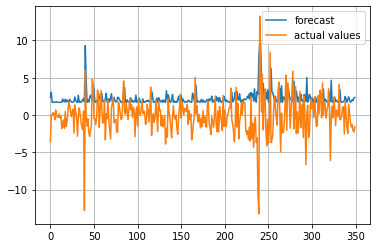

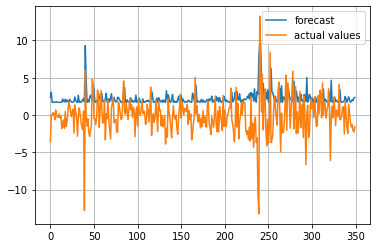

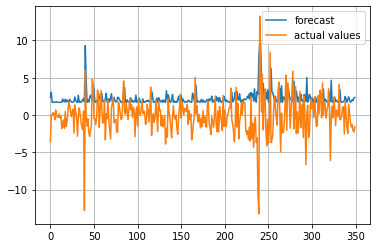

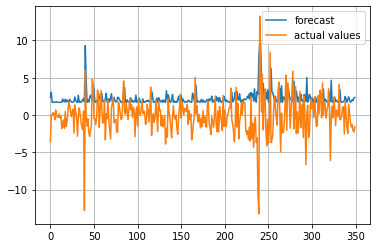

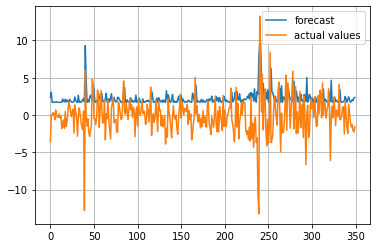

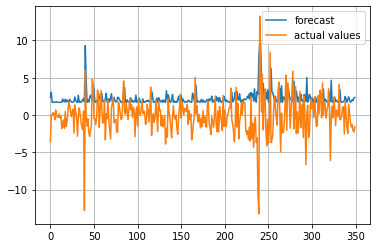

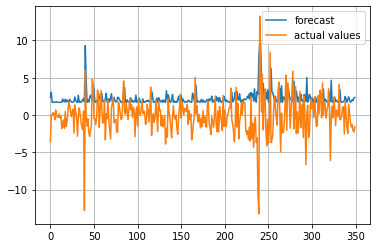

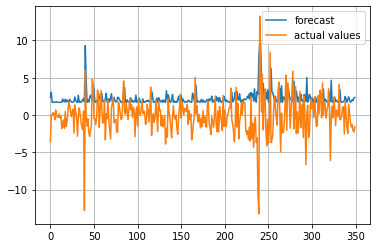

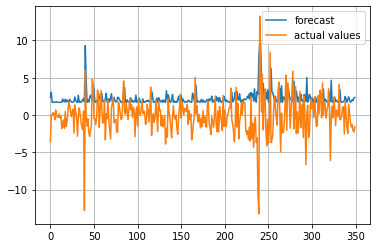

In [22]:
for fvm in res['fvms']:
    plt.plot(fvm.h[:-1] ** .5, label='forecast')
    plt.plot(fvm.train_data.values, label='actual values')

    plt.legend()
    plt.grid()
    plt.show()

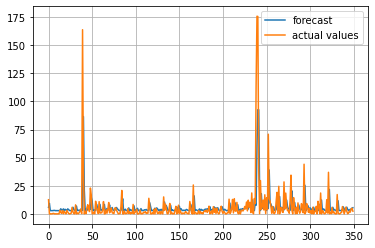

In [50]:
plt.plot(fvm.h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()